# Demonstration File

In [1]:
#Import necessary libraries
import test_manifold_algorithms as tma
from MASH import MASH
from SPUD import SPUD
from temporal_progression_comparisons import *
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

#Prep the domains
#dc = tma.test_manifold_algorithms("seeds.csv", split = "even", verbose = 3, random_state=2816)

2024-08-13 15:35:34.577537: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-13 15:35:34.583440: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-13 15:35:34.686292: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-13 15:35:36.641000: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


This is not running as __main__


# Testing with Profile Variables

In [8]:
profile_raw = pd.read_excel("/yunity/arusty/Graph-Manifold-Alignment/CSV Files/Profile Variables 2024-07-31.xlsx", index_col="RID")
#come back to this later, we shouldn't have to deal with nans like this
#get rid of problematic columns and patients with no data
profile = profile_raw.drop(columns = ["PTRACCAT"]).dropna(how="all")
#remap a few variables, might make part of the merge later
profile['DX_bl'] = profile['DX_bl'].map({'CN': 0, 'SMC': 1, 'EMCI': 2, 'LMCI': 3, 'AD': 4, 'NaN': -4})
profile['PTMARRY'] = profile['PTMARRY'].map({'Married': 1, 'Widowed': 2, 'Divorced': 3, 'Never married': 4, 'Unknown': -4, 'NaN': -4})
#profile.fillna(-4, inplace=True)

In [9]:
profile.sample(5)

,PTEDUCAT,PTHAND,MOTHAD,FATHAD,MOTHDEM,FATHDEM,DX_bl,AGE,PTMARRY,AB42_RAW,...,PTGENDER,PTDOBYY,PTPLANG,PTETHCAT,PTIDENT,PTENGSPK,PTETHCATH,Mean,SD,CV
RID,,,,,,,,,,,,,,,,,,,,,
4558,20.0,1.0,NaN,NaN,NaN,NaN,0.0,70.0,1.0,NaN,...,2.0,1942.0,1.0,2.0,NaN,NaN,NaN,243.607895,8.876161,0.036436
4266,14.0,1.0,NaN,NaN,NaN,NaN,0.0,69.8,1.0,148.0,...,2.0,1941.0,1.0,2.0,NaN,NaN,NaN,202.969038,7.605982,0.037474
339,14.0,1.0,NaN,NaN,NaN,NaN,3.0,86.0,1.0,NaN,...,1.0,1921.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN
4740,12.0,1.0,NaN,NaN,NaN,NaN,4.0,88.3,1.0,NaN,...,1.0,1924.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN
4883,18.0,1.0,NaN,NaN,NaN,NaN,2.0,76.1,2.0,NaN,...,2.0,1936.0,1.0,2.0,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
domain_a = np.array(profile)[:200, :20].astype(float)
domain_b = np.array(profile)[:200, 20:].astype(float)

In [17]:
dc = tma.test_manifold_algorithms("seeds.csv", split = "even", verbose = 3, random_state=2816)
#dc.anchors[:22]


 
 
---------------------------       Initalizing class with seeds.csv data       ---------------------------

Spliting the data evenly
Split A features shape: (199, 4)
Split B Features shape (199, 3)
MDS initialized with 3 components
The knn values are: (2, 6, 10, 14, 18, 22, 26, 30, 34, 38)


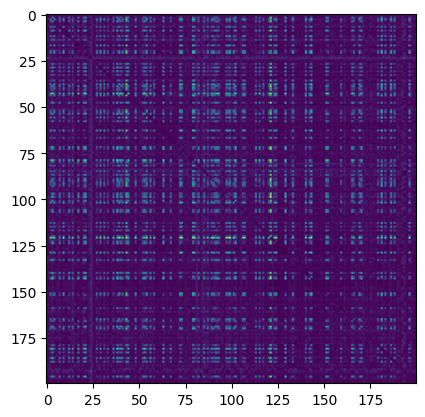

In [24]:
import numpy as np
from scipy.spatial.distance import squareform
import matplotlib.pyplot as plt

def nan_pairwise_distances(data, metric='euclidean'):
    def nan_distance(u, v):
        mask = ~np.isnan(u) & ~np.isnan(v)
        if np.any(mask):
            if metric == 'euclidean':
                return np.linalg.norm(u[mask] - v[mask]) / np.sqrt(mask.sum())
            elif metric == 'manhattan':
                return np.sum(np.abs(u[mask] - v[mask])) / mask.sum()
            elif metric == 'cosine':
                return 1 - np.dot(u[mask], v[mask]) / (np.linalg.norm(u[mask]) * np.linalg.norm(v[mask]))
            # Add more metrics as needed
        else:
            return np.nan

    n = data.shape[0]
    distances = np.zeros((n * (n - 1)) // 2)
    k = 0
    for i in range(n - 1):
        for j in range(i + 1, n):
            distances[k] = nan_distance(data[i], data[j])
            k += 1

    return squareform(distances)

#data = np.array([[1, 2, np.nan], [4, np.nan, 6], [7, 8, 9]])
dist_matrix = nan_pairwise_distances(domain_a, metric='euclidean')
plt.imshow(dist_matrix)


array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True, False, ..., False, False, False],
       [ True, False,  True, ..., False,  True,  True],
       ...,
       [ True, False, False, ...,  True,  True,  True],
       [ True, False,  True, ...,  True,  True,  True],
       [ True, False,  True, ...,  True,  True,  True]])

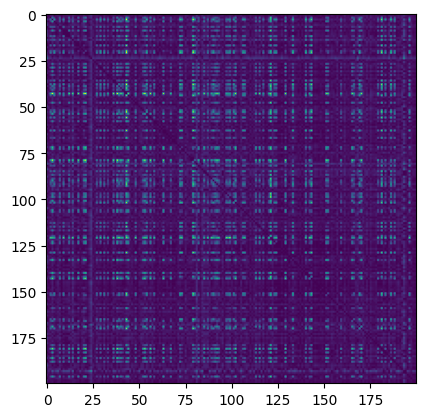

In [49]:
from scipy.spatial.distance import pdist, squareform, euclidean, cityblock, cosine

def nan_metric(u, v, metric):
    # Mask for valid (non-NaN) entries
    valid_mask = np.isfinite(u) & np.isfinite(v)
    if np.sum(valid_mask) == 0:
        return np.nan  # If no valid entries, return NaN
    # Calculate the distance using the specified metric only on valid entries
    dist = metric(u[valid_mask], v[valid_mask])
    # Normalize by the number of valid entries
    return dist / np.sum(valid_mask)


# Calculate the distance matrix
plt.imshow(squareform(pdist(domain_a, metric= lambda u, v: nan_metric(u, v, cityblock))))

In [50]:

#Install the libraries
from scipy.spatial.distance import pdist, squareform, _METRICS
import graphtools
import numpy as np
import matplotlib.pyplot as plt
import igraph as ig
from sklearn.manifold import MDS
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from Triangular import *


def get_SGDM(data, distance_measure):
    """SGDM - Same Graph Distance Matrix.
    This returns the normalized distances within each domain."""

    #Check to see if it is a function
    if callable(distance_measure):
      return distance_measure(data)

    #If the distances are precomputed, return the data. 
    elif distance_measure.lower() == "precomputed":
      return data
    
    #Euclidian
    elif distance_measure.lower() in _METRICS:

      #Check to make sure we have no NaNs. If we do, we will change the algorihm
      if np.isnan(data).any():

        #Proceed with the NanN adjustments by creating a custom nan function we can pass into pdist
        def nan_metric(u, v, metric):
          # Mask for valid (non-NaN) entries
          valid_mask = np.isfinite(u) & np.isfinite(v)
          if np.sum(valid_mask) == 0:
              return np.nan  # If no valid entries, return NaN
          # Calculate the distance using the specified metric only on valid entries
          dist = metric(u[valid_mask], v[valid_mask])
          # Normalize by the number of valid entries
          return dist / np.sum(valid_mask)
        
        dists = squareform(pdist(domain_a, metric = lambda u, v: nan_metric(u, v, metric = _METRICS[distance_measure.lower()])))
        
      else:
        #Just using a normal distance matrix without Igraph
        dists = squareform(pdist(data, metric = distance_measure.lower())) #Add it here -> if its in already for additionally block

    else:
      raise RuntimeError(f"Did not understand {distance_measure}. Please provide a function, or use strings 'precomputed', or provided by sk-learn.")


    return dists
    #Normalize it and return the data
    #return get_triangular(self.normalize_0_to_1(dists))

#plt.imshow(get_SGDM(domain_a, distance_measure="euclidean"))
get_SGDM(domain_a, distance_measure="euclidean")

TypeError: 'str' object is not callable

In [51]:
type(_METRICS)

dict

In [ ]:
#spud_time.fit(dataA = domain_a, dataB = domain_b, known_anchors=dc.anchors[:22])
spud_time = SPUD(knn = 2, verbose = 2)
profile_anchors = [[x,x] for x in range(len(domain_a))]
spud_time.fit(dataA = domain_a, dataB = domain_b, known_anchors=profile_anchors)

/yunity/arusty/.local/lib/python3.10/site-packages/graphtools/graphs.py:236: UserWarning: Metric euclidean not valid for `sklearn.neighbors.BallTree`. Graph instantiation may be slower than normal.
  warnings.warn(


ValueError: Input X contains NaN.
NearestNeighbors does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

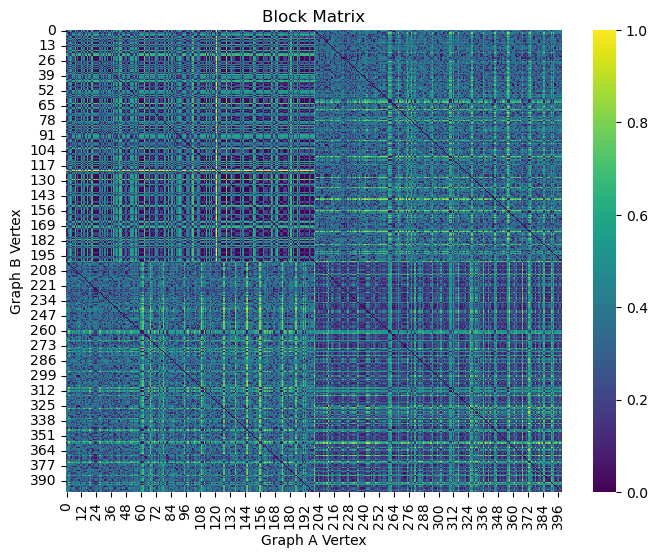

In [8]:
spud_time.plot_heat_map()

c:\Users\jcory\anaconda3\Lib\site-packages\sklearn\manifold\_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


Cross Embedding: 0.51
FOSCTTM: 0.0


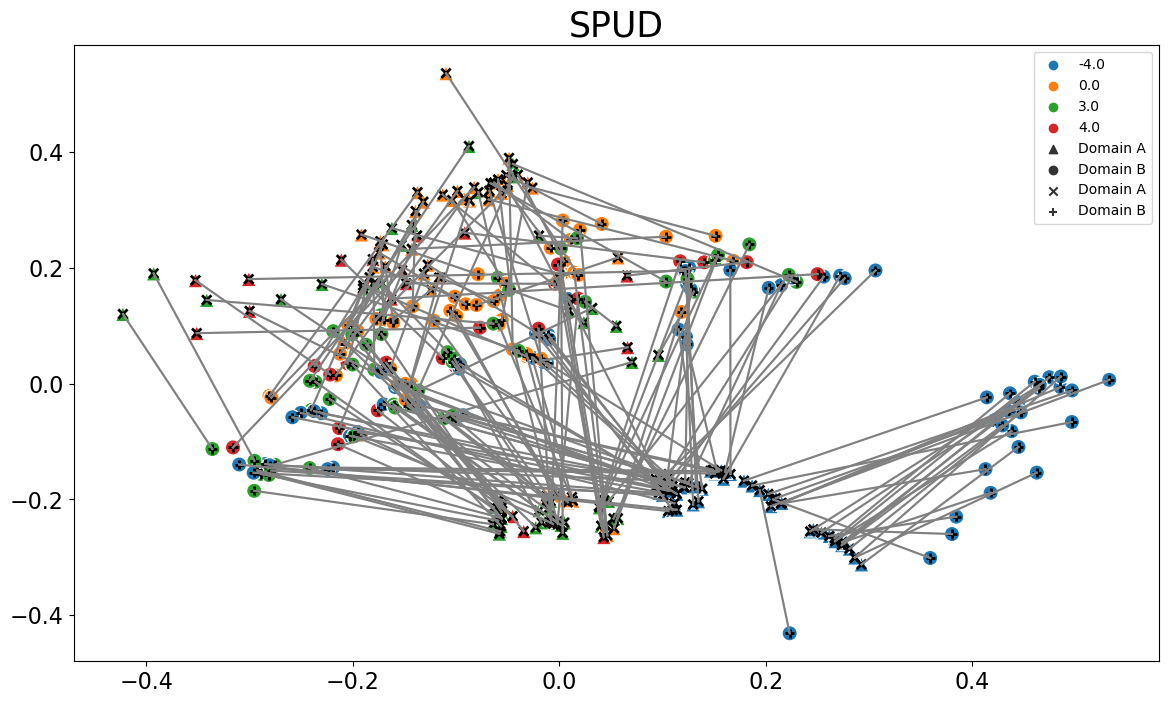

In [9]:
spud_time.plot_emb(labels = pd.concat([profile["DX_bl"][:200], profile["DX_bl"][:200]]))

# Testing with Profile and Visit variables

In [44]:
#Create dataclasses. Note, we want to distort to leave domain unchanged
#profile_data = tma.test_manifold_algorithms("Profile Variables 2024-07-09.csv", split = "distort", verbose = 3, random_state=2816)
#visits_data = tma.test_manifold_algorithms("Visit Variables 2024-07-09.csv", split = "distort", verbose = 3, random_state=2816)
profile_data = profile
visits_data = pd.read_excel(r"C:\Users\jcory\Box\Graph-Manifold-Alignment\CSV Files\Visit Variables 2024-08-01.xlsx", index_col = [0])


In [46]:
#build the anchors list from the indecies of the corresponding RID labels
profile_labels = list(profile_data.index.values)
visits_labels = list(visits_data.index.values)

#for each visit on record, create an anchor that connects it to the approprate profile entry
#note that every visit will have an anchor but some of the profiles will not because they dropped out of the study
anchors = []
for x in range(len(visits_labels)):
    rid = visits_labels[x]
    corresponding_profile_position = profile_labels.index(rid)
    new_anchor = [corresponding_profile_position, x]
    anchors.append(new_anchor)

In [47]:
#Create the subsets to be used for each domain
domain_a = np.array(profile_data)[:52, :].astype(float) #there are 52 profiles represented in the first 200 visits
domain_b = np.array(visits_data)[:200, :].astype(float)
#Reset NaN values to be -4 :)
domain_a[np.isnan(domain_a)] = -4
domain_b[np.isnan(domain_b)] = -4

#Lets subset the data
#profile_data.split_A = profile_data.split_A[:SUBSET_VAL]
#visits_data.split_A = visits_data.split_A[:max(TV_anchors[:, 1])+1]

In [48]:
len(anchors), len(domain_a), len(domain_b), anchors[-10:]

(11575,
 52,
 200,
 [[4058, 11565],
  [4065, 11566],
  [4069, 11567],
  [4069, 11568],
  [4077, 11569],
  [4080, 11570],
  [4084, 11571],
  [4085, 11572],
  [4086, 11573],
  [4088, 11574]])

In [53]:
#Create the merged values --> This will take up the rest of your day
pv_spud = SPUD(n_pca = 10)
pv_spud.fit(domain_a, domain_b, known_anchors = anchors[:200])

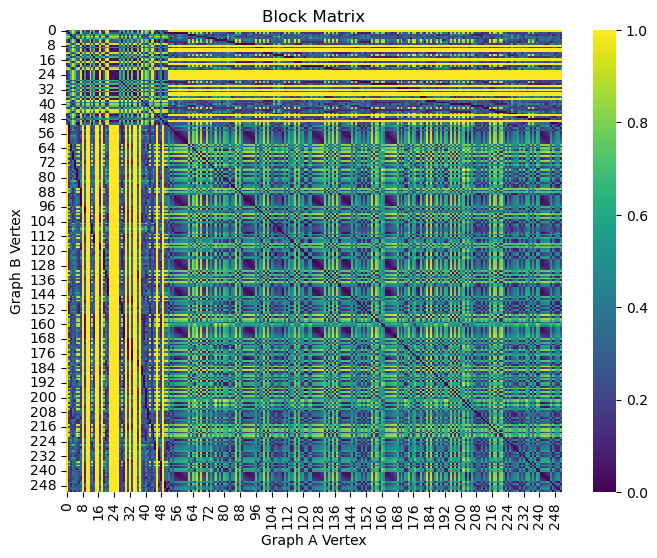

In [54]:
pv_spud.plot_heat_map()

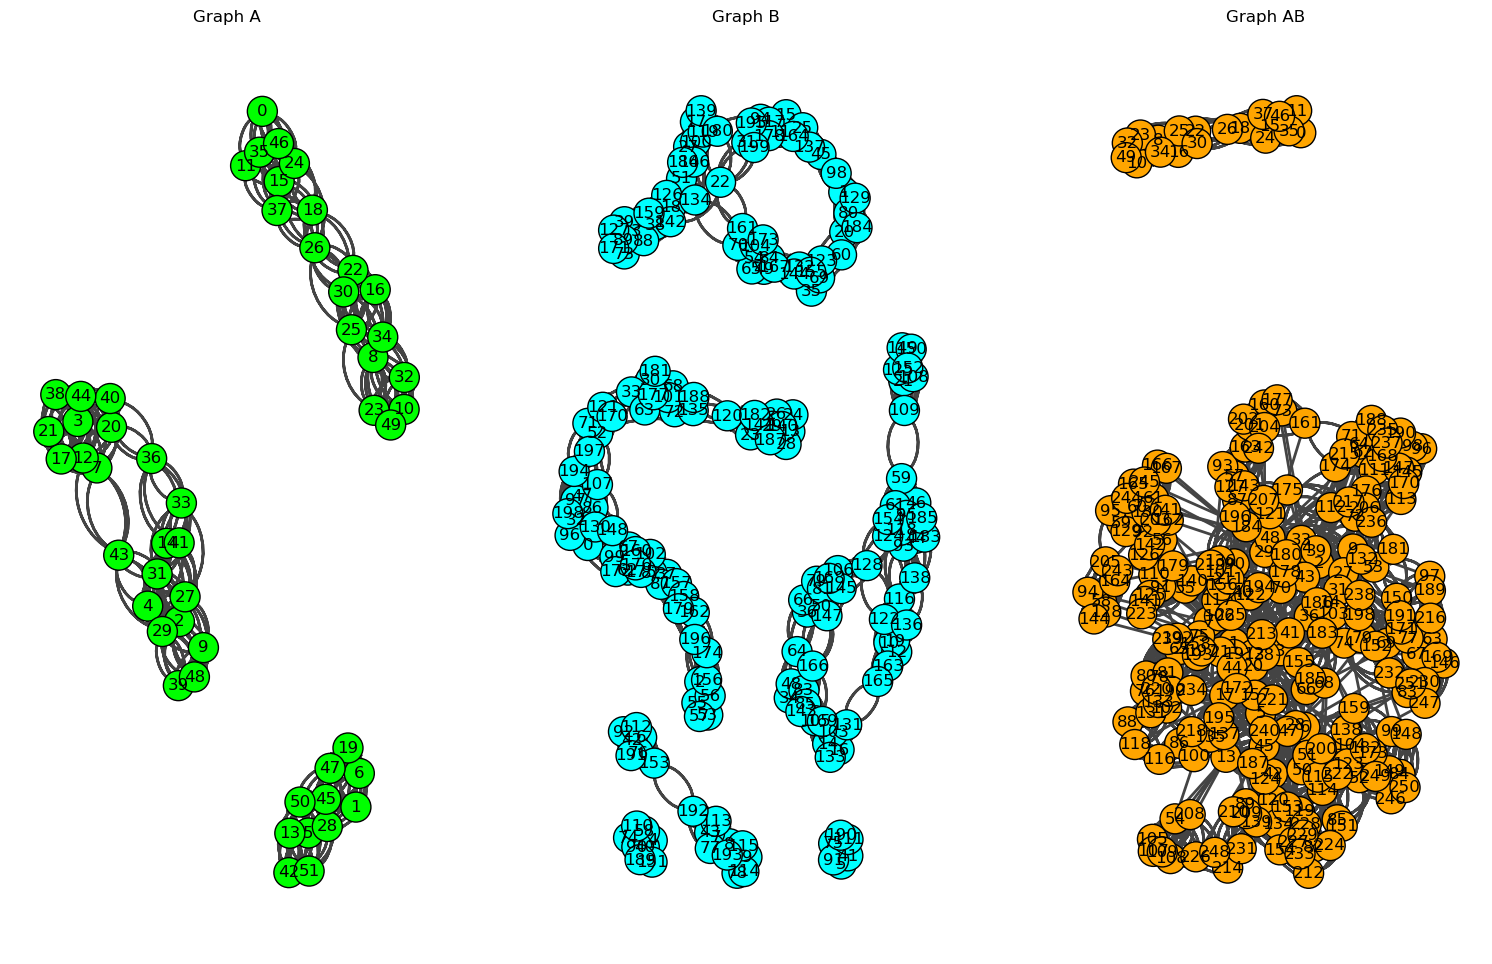

Cross Embedding: 0.3194230769230769
Can't compute FOSCTTM with different domain shapes.


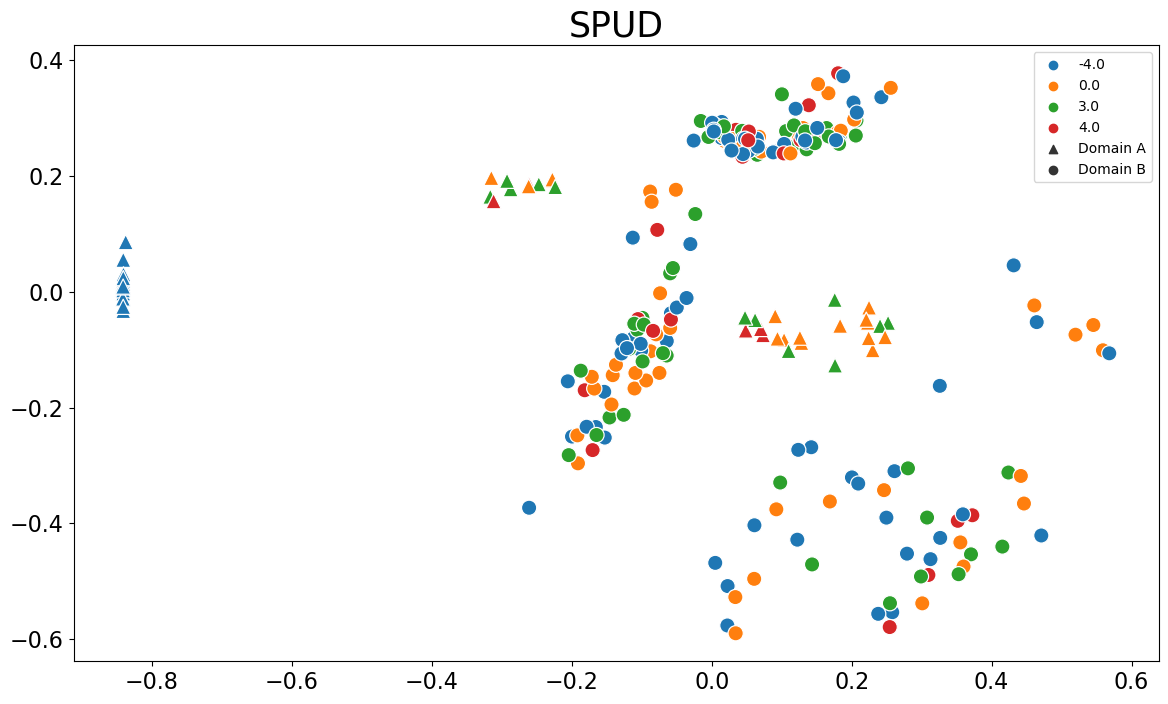

In [58]:
labels = pd.concat([profile["DX_bl"][:52], profile["DX_bl"][:200]])

pv_spud.plot_graphs()
pv_spud.plot_emb(labels = labels, show_anchors = False, show_lines = False, n_comp = 2)

# Testing with Profile and Progression Variables

In [3]:
from temporal_progression_comparisons import *
import numpy as np
import pandas as pd

progressions_data = pd.read_excel(r"C:\Users\jcory\Box\Graph-Manifold-Alignment\CSV Files\Progression Variables 2024-08-02.xlsx", index_col=[0,1])

def get_distances(data, distance_measure):
    if callable(distance_measure):
        return distance_measure(data)
    
final = get_distances(df, wrapped_euclidean_distances)

2
2
2
2
2
2
2
2
2
2
3
3
3
3
3
3
3
3
3
3
4
4
4
4
4
4
4
4
4
4
5
5
5
5
5
5
5
5
5
5
6
6
6
6
6
6
6
6
6
6
7
7
7
7
7
7
7
7
7
7
8
8
8
8
8
8
8
8
8
8
10
10
10
10
10
10
10
10
10
10
14
14
14
14
14
14
14
14
14
14
15
15
15
15
15
15
15
15
15
15
